<a href="https://colab.research.google.com/github/MarissaNorlund/Norlund-2025/blob/main/Python%20Image%20Reduction/Prose_booklet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Jan. 24, 2025**
---

* I used *pip install* and installed the program Prose from **[lgrcia](https://github.com/lgrcia/prose)** on GitHub, and started working on the "Quickstart" code that was in their book.
* Continued on to the Core Objects module, and finished the day with the Fits Manager section.

# Quickstart and Core Objects
---
* Point Spread Function (**PSF**) describes what a single point in the object looks like in the image.
* "***Prose*** contains the structure to build modular image processing pipelines with three key
objects: **Image** going
through a list of **Block** assembled into a **Sequence**."
  * An **Image** contains the image data and metadata.
  * A **Block** is a single unit of processing acting on the **Image** object, which can read and write its attributes, or modify.
  * A **Sequence** is a succession of **Block**.

In [ ]:
pip install 'prose @ git+https://github.com/lgrcia/prose'

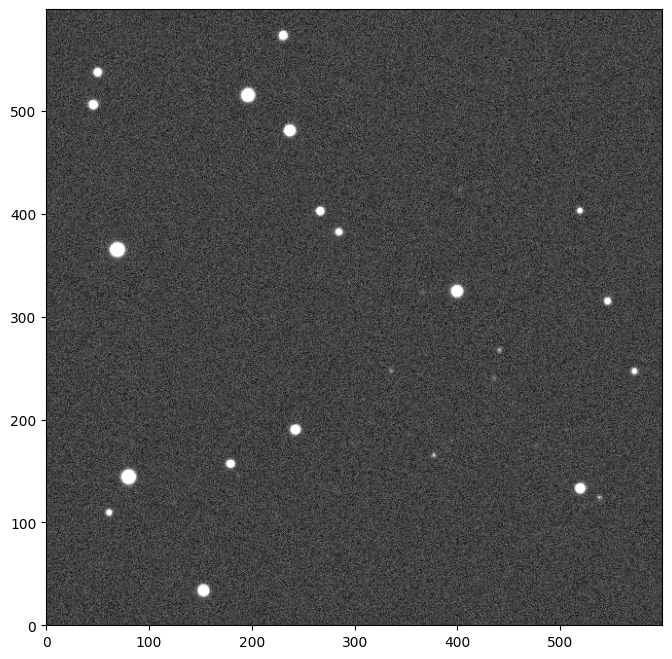

In [ ]:
# Loading in an example image.

from prose import Sequence, blocks, example_image
import matplotlib.pyplot as plt

# getting the example image
image = example_image()
image.show()

  0%|          | 0/1 [00:00<?, ?images/s]

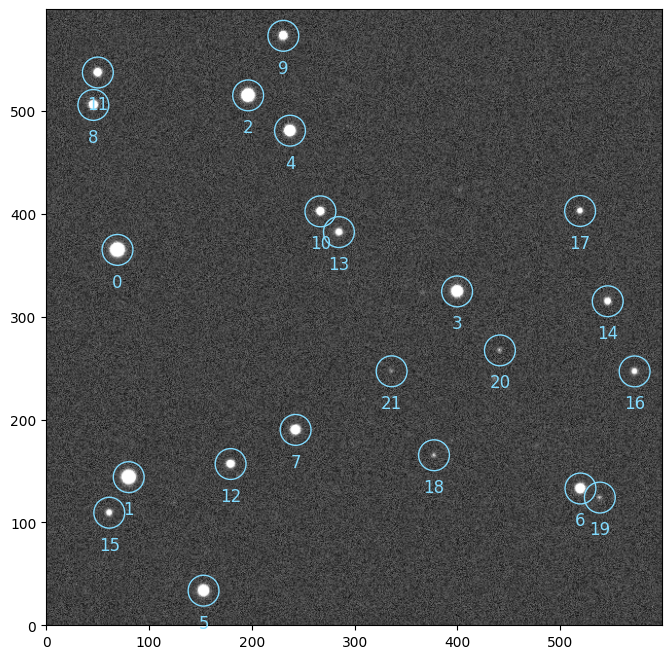

In [ ]:
# Building a Sequence containing single processing units
# called Block that will process our image.

sequence = Sequence(
    [
        blocks.PointSourceDetection(),  # stars detection
        blocks.Cutouts(21),             # cutouts extraction
        blocks.MedianEPSF(),            # PSF building
        blocks.Moffat2D(),              # PSF modeling
    ]
)

sequence.run([image])

# plotting the detected stars
image.show()

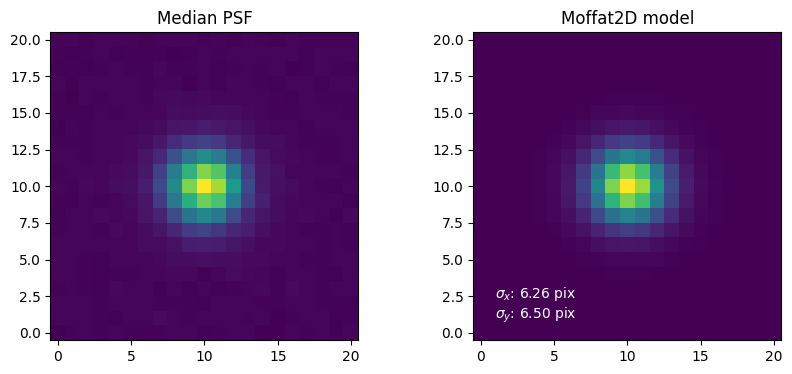

In [ ]:
# Plotting the results of the PSF building and modeling from the Image attributes.

plt.figure(None, (10, 4))

# PSF building
plt.subplot(1, 2, 1, title="Median PSF")
plt.imshow(image.epsf.data, origin="lower")

# PSF modeling
params = image.epsf.params
model = image.epsf.model

plt.subplot(1, 2, 2, title=f"Moffat2D model")
plt.imshow(model(params), origin="lower")
_ = plt.text(
    1,
    1,
    f"$\sigma_x$: {params['sigma_x']:.2f} pix\n$\sigma_y$: {params['sigma_y']:.2f} pix",
    c="w",
)

In [ ]:
from prose import Image, Block, Sequence
import numpy as np

np.random.seed(42)
images = [Image(data=np.random.rand(10, 10)) for i in range(5)]

In [ ]:
class HelloWorld(Block):
    def run(self, image):
        image.mean = np.mean(image.data)
        print(f"Hello world (mean: {image.mean:.2f})")

In [ ]:
sequence = Sequence(
    [
        HelloWorld(),
    ]
)

sequence.run(images)

  0%|          | 0/5 [00:00<?, ?images/s]

Hello world (mean: 0.47)
Hello world (mean: 0.50)
Hello world (mean: 0.52)
Hello world (mean: 0.49)
Hello world (mean: 0.52)


# **Tutorials:**
# Fits Manager
---

* The **Fits Manager** assists in the process of sorting fits image folders, and makes the process of finding needed images go faster.

* In cell **four** the keywords of all images have been parsed and associated with different telescopes.
  * The advantage is that specific keywords from specific telescopes are recognized and standardized to common namings.
  * This is useful to define telescope agnostic pipelines.

## Telescope Specific Keywords
---

* The information retained by **FitsManager** was taken from images headers.
  * To know which keywords to use, we had to register telescopes A and B with a dictionary.
  * Whenever their names appear in a fits header, their dictionary is loaded to read their header keywords.

* Since we just specified the telescope names all the rest is default.
  * For example the filter is taken from the keyword **FILTER** and the image type from **IMAGETYP**, knowing that **IMAGETYP=light** is a light (a.k.a science) frame.
  * These keywords can be set in more details when registering the telescope.

* For more details, check the **Telescope** object:

      from shutil import rmtree

      rmtree(destination)



In [ ]:
from prose import FitsManager, Telescope
from prose import simulations

In [ ]:
# Example of how the Fits Manager is used.
# Here we are generating a set of fake data from telescope 'A' and 'B'.

_ = Telescope(name="A", save=True)
_ = Telescope(name="B", save=True)

Telescope 'a' saved
Telescope 'b' saved


In [ ]:
# Images will be located in a single folder, featuring different sizes,
# filters and associated calibration files, with no way to distinguish them from their file names.

destination = "./fake_observations"
simulations.disorganised_folder(destination)

In [ ]:
# This instates a FitsManager object that goes into a disorganised folder.

fm = FitsManager(destination)
fm

Parsing FITS:   0%|          | 0/28 [00:00<?, ?it/s]

date telescope filter   type target  width  height  files
id                                                                 
1   2025-01-30         B      b  light  prose     10      20      5
8   2025-01-30    Spirit          dark  prose     10      10      2
7   2025-01-30    Spirit      a  light  prose     10      10      5
6   2025-01-30    Spirit     ab  light  prose     10      10      5
3   2025-01-30    Spirit      b   flat  prose     10      10      2
2   2025-01-30    Spirit      b  light  prose     10      10      5
4   2025-01-30    Spirit      c   dark  prose     10      10      2
5   2025-01-30    Spirit      c   flat  prose     10      10      2

In [ ]:
# Keeps the files from an observation using its id.
# Flats with the right filter have been kept, as well as darks.

files = fm.observation_files(1)

/usr/local/lib/python3.11/dist-packages/prose/io/fitsmanager.py:537: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, axis=0).set_index(["id"])


date telescope filter   type target width height  exposure files
id                                                                        
1   2025-01-30         B      b  light  prose    10     20       1.0     5

# **Jan. 27-28, 2025**
---

* I started working on the Images Photometry Section on the 27th, and I finished it up on the 28th before starting work on the Custom Block section.
* After finishing the block section, I started working on Catalogues & Plate Solving.

# Images Photometry
---

* This shows how to process a complete night of raw data from any telescope by building a data reduction **Sequence**.
* The code tutorial can be used for personal or synthetic data.

## Extracting Photometry
---

* The first thing that must be done is choosing a reference image that will be used for all other images.
* The things that are extracted from the reference image include:
  * The position of the stars.
    * This will be used on all following images to align them with the reference.
  * The global full-width at half-max (fwhm) of the PSF.
    * This will be used to scale the apertures used in the aperture photometry block.
* In cell 5, **Gaia** query can be used to define which stars you want the photometry from if the stars are too faint to be detected with this.

## Aperture Photometry
---

* For cell 6, *photometry.run* has had a *loader* specified to it, and instead of passing a list of **Image** objects, we passed a list of *image paths*.
  * Through this we are not able to access the individual images and their data, but wee are able to process a lot more without it having to be stored into memory.
  * Images are loaded, processed, and deleted in memory.

## The Fluxes Object
---

* The **GetFluxes** block provide a way to retrieve the fluxes computed by the **AperturePhotometry** minus the background estimated with **AnnulusBackground**.
      import shutil

      shutil.rmtree(fits_folder)

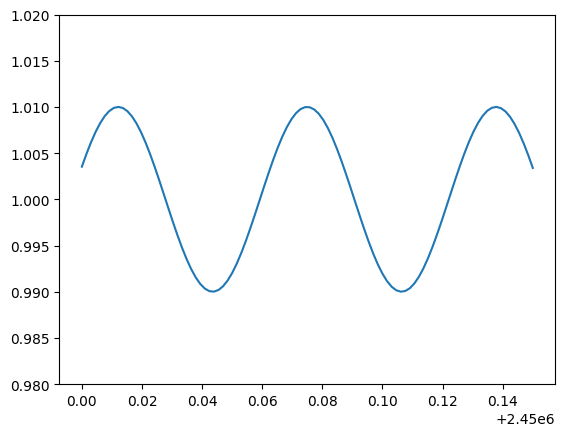

In [ ]:
# Here we are creating a light curve.
# Might be the differential flux of a variable star.

import numpy as np
import matplotlib.pyplot as plt
from prose.simulations import simulate_observation

time = np.linspace(0, 0.15, 100) + 2450000
target_dflux = 1 + np.sin(time * 100) * 1e-2

plt.plot(time, target_dflux)
_ = plt.ylim(0.98, 1.02)

In [ ]:
# Simulates the fits images associated with the observation of this target.
# Prose simulated comparison stars, their fluxes over time and some systematics noises.
# so we have the same data

np.random.seed(40)

fits_folder = "./tutorial_dataset"
simulate_observation(time, target_dflux, fits_folder)

100%|██████████| 100/100 [00:08<00:00, 11.99it/s]


In [ ]:
# Here we are seeing what is in our folder, and using FitsManager to describe the content of it.
# We have 100 images of the prose target together with some calibration files.

from prose import FitsManager

fm = FitsManager(fits_folder, depth=2)
fm

Parsing FITS:   0%|          | 0/106 [00:00<?, ?it/s]

date telescope filter   type target  width  height  files
id                                                                 
3   2025-01-30    Spirit          bias  prose    600     600      1
4   2025-01-30    Spirit          dark  prose    600     600      1
2   2025-01-30    Spirit      a   flat  prose    600     600      4
1   2025-01-30    Spirit      a  light  prose    600     600    100

In [ ]:
# FITSImage is the primary function used to load a FITS image into an Image object.

from prose import FITSImage

ref = FITSImage(fm.all_images[0])

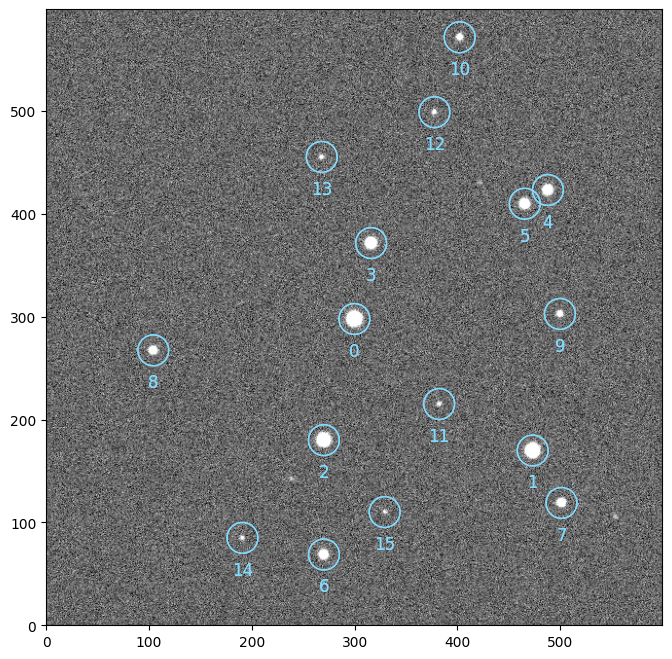

In [ ]:
# Builds a sequence to process the reference image.

from prose import Sequence, blocks

calibration = Sequence(
    [
        blocks.Calibration(darks=fm.all_darks, bias=fm.all_bias, flats=fm.all_flats),
        blocks.Trim(),
        blocks.PointSourceDetection(),  # stars detection
        blocks.Cutouts(21),  # making stars cutouts
        blocks.MedianEPSF(),  # building PSF
        blocks.psf.Moffat2D(),  # modeling PSF
    ]
)

calibration.run(ref, show_progress=False)

ref.show()
ref.sources.plot()

In [ ]:
radii = np.linspace(0.2, 4, 30)

photometry = Sequence(
    [
        *calibration,  # calibration
        blocks.ComputeTransformTwirl(ref),  # compute alignment
        blocks.AlignReferenceSources(ref),  # alignment
        blocks.CentroidQuadratic(),  # centroiding
        blocks.AperturePhotometry(radii=radii),  # aperture photometry
        blocks.AnnulusBackground(),  # local background estimate
        blocks.GetFluxes(),
    ]
)

photometry.run(fm.all_images, loader=FITSImage)

  0%|          | 0/100 [00:00<?, ?images/s]

In [ ]:
raw_fluxes = photometry[-1].fluxes

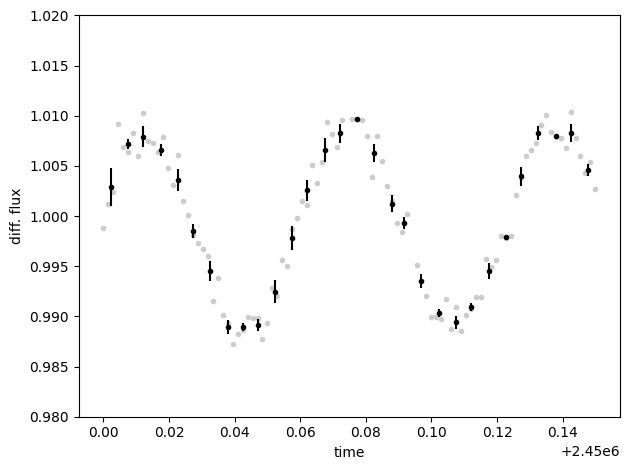

In [ ]:
# Autodiff produced the differential photometry

# picking target
raw_fluxes.target = 0

# good practice
raw_fluxes = raw_fluxes.sigma_clipping_data(bkg=3)

# differential photometry
diff_fluxes = raw_fluxes.autodiff()
diff_fluxes.plot()
diff_fluxes.bin(0.005, True).errorbar()

plt.ylim(0.98, 1.02)
plt.xlabel("time")
plt.ylabel("diff. flux")
plt.tight_layout()

# Custom Block
---

* This section shows more detailed example on how to create a custom block by subclassing the **Block** class, and thus making it more user-friendly.
  * The example shown here is a **Block** that corrects for image vingetting.

## Method
---

1.  We build a sigma-clipped version of the image to exclude bright (stars) pixels (iteratively). (**Cell 3**)
2.  We fit the vignette model to the sigma clipped data. (**Cell 4**)
3.  We correct the image from the fitted vignette. (**Cell 5**)

## Block Creation
---

* Next we are creating a block to be able to apply this correction in a **Sequence**.
  * This way it will be easier to associate it to other processing blocks.
* The simpliest way is to subclass the **Block** class, and copy-paste the code above cell 6 into its run(self, image) method, which will be called on each **Image**



In [ ]:
from prose import example_image

image = example_image(seed=4)

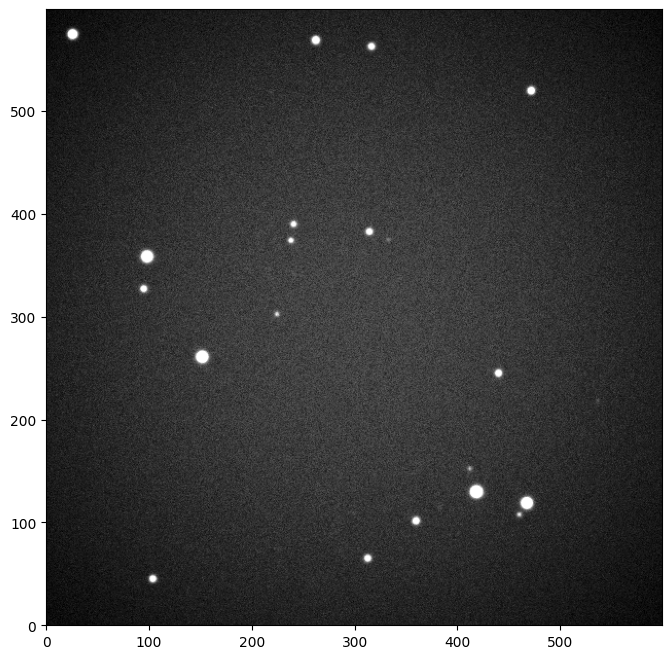

In [ ]:
import numpy as np


# vignette function
def gaussian2D(XY, xy, sigma, amplitude=1):
    X, Y = XY
    x, y = xy
    return (
        amplitude
        * np.exp(-((X - x) ** 2 / sigma**2) - ((Y - y) ** 2 / sigma**2)) ** 3
    )


# vignetting the image data
XY = np.indices(image.shape)
vignette = gaussian2D(XY, (np.array(image.shape) / 2), 1000)
image.data *= vignette
image.show()

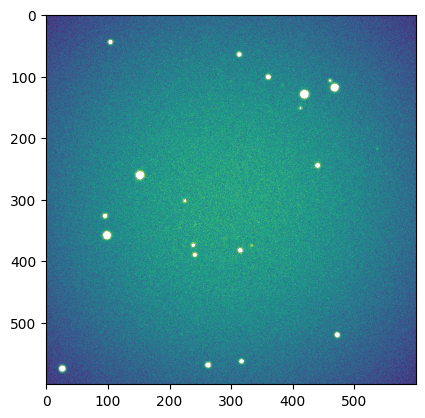

In [ ]:
import matplotlib.pyplot as plt

sg_image = image.data.copy()

sg_image = image.data.copy()
mask = np.ones_like(sg_image).astype(bool)
for _ in range(5):
    mask = np.abs((sg_image - np.median(sg_image[mask]))) < 5 * np.std(sg_image[mask])
sg_image[~mask] = np.nan

plt.imshow(sg_image)

In [ ]:
from scipy.optimize import minimize

center = np.array(image.shape) / 2


def model(p):
    a, s = p
    return a * gaussian2D(XY, center, s)


def nll(p, sg_image):
    _model = model(p)
    return np.log(np.nansum((_model - sg_image) ** 2))


x0 = [5000, image.shape[0]]
sol = minimize(nll, x0, bounds=((0, np.nanmax(sg_image)), (0, 2000)), args=(sg_image,))

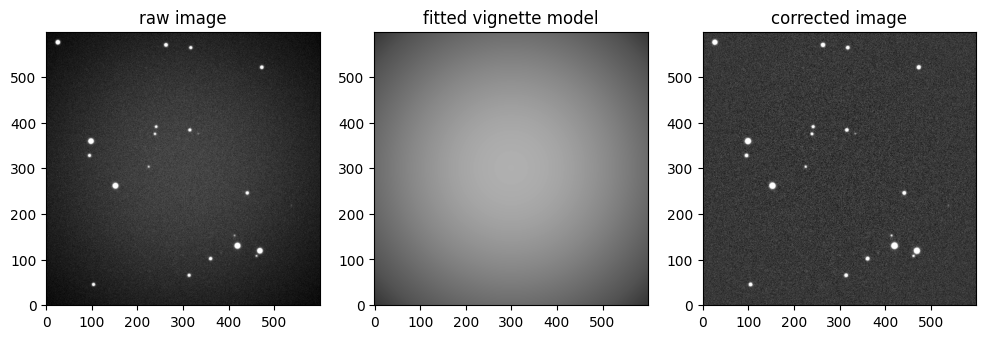

In [ ]:
corrected_image = image.copy()
corrected_image.data -= model(sol.x)

# plotting
# --------
plt.figure(None, (12, 6))

ax1 = plt.subplot(131, title="raw image")
image.show(ax=ax1)

ax2 = plt.subplot(132, title="fitted vignette model")
plt.imshow(
    model(sol.x),
    origin="lower",
    cmap="Greys_r",
    vmin=np.nanmin(sg_image),
    vmax=np.nanmax(sg_image),
)

ax3 = plt.subplot(133, title="corrected image")
_ = corrected_image.show(ax=ax3)

In [ ]:
from prose import Block


class SimpleVignettingCorr(Block):
    def __init__(self, **kwargs):
        super().__init__(self, **kwargs)

    def run(self, image):
        # 1. Sigma clipping
        sg_image = image.data.copy()
        mask = np.ones_like(sg_image).astype(bool)
        for _ in range(5):
            mask = np.abs((sg_image - np.median(sg_image[mask]))) < 5 * np.std(
                sg_image[mask]
            )
        sg_image[~mask] = np.nan

        XY = np.indices(image.shape)
        center = np.array(image.shape) / 2

        # 2. Fitting the model
        def model(p):
            a, s = p
            return a * gaussian2D(XY, center, s)

        def nll(p, sg_image):
            _model = model(p)
            return np.log(np.nansum((_model - sg_image) ** 2))

        x0 = [5000, image.shape[0]]
        sol = minimize(
            nll, x0, bounds=((0, np.nanmax(sg_image)), (0, 2000)), args=(sg_image,)
        )

        # correction
        image.data -= model(sol.x)

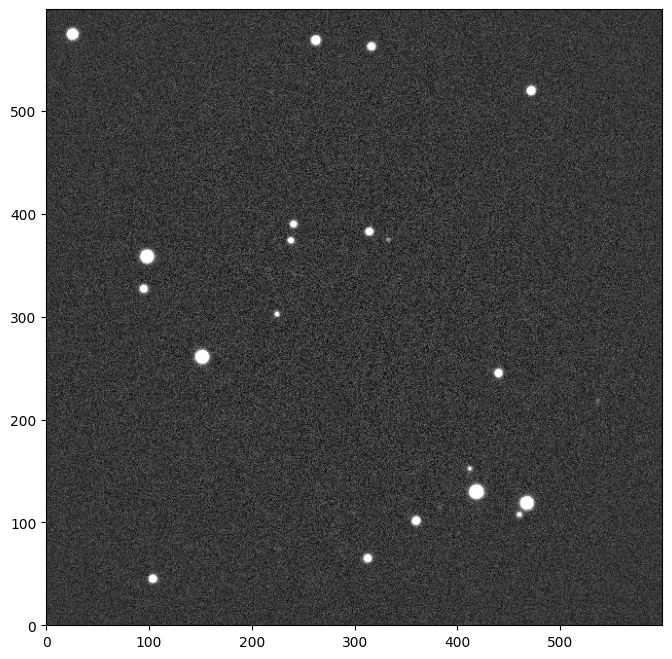

In [ ]:
# This applies what was done in the previous cell to the data.

corrected_image = SimpleVignettingCorr()(image)
_ = corrected_image.show()

# User-Friendly Block
---

* The previous **Block** does the work, but it is not optimized.
  1. *XY* and *center* are computed for each image, whereas images with similar characteristics (like shape and center) are more likely to be fed into a sequence.
  2. The model parameters optimisation always start from an uninformed guess *x0*, whereas the solution from a previous image is likely to be a good guess.
  3. The code within *run* is lengthy and could be organized using class methods.
* A good way to solve 1. is to provide the block with a reference image, from which XY and center can be pre-computed.
* To solve 2., the last optmized parameters can be recorded and used as a first guess for the next optimization.
* Implementing these two ideas in the block together with a bit of cleaning solves 3.

    * Here, the performance of *BetterVignettingCorr* against *SimpleVignettingCorr* would be very similar, but providing a reference mechanism to a block (so it can precompute some redundant parameters) often greatly improves its performances.
    * Acknowledgement section for this block is in the book, and will be used later.

In [ ]:
class BetterVignettingCorr(Block):
    # allowing for a reference image to be provided
    def __init__(self, reference=None, **kwargs):
        super().__init__(self, **kwargs)

        # to avoid re-computing it for every new image
        self.XY = None
        self.center = None

        # to save last optimized parameters
        self.x0 = None

        # pre-computing parameters if reference provided
        if reference is not None:
            self.XY = np.indices(reference.shape)
            self.center = np.array(reference.shape) / 2
            self.x0 = [5000, reference.shape[0]]

    @staticmethod
    def sigma_clip(data, n=5, sigma=5):
        sg_image = data.copy()
        mask = np.ones_like(sg_image).astype(bool)
        for _ in range(5):
            mask = np.abs((sg_image - np.median(sg_image[mask]))) < 5 * np.std(
                sg_image[mask]
            )
        sg_image[~mask] = np.nan
        return sg_image

    def model(self, p):
        a, s = p
        return a * gaussian2D(self.XY, self.center, s)

    def chi(self, p, sg_image):
        model = self.model(p)
        return np.nansum((model - sg_image) ** 2)

    def run(self, image):
        # sigma clipping
        sg_image = self.sigma_clip(image.data)

        # if no reference, using first image to initialize parameters
        if self.x0 is None:
            self.x0 = [5000, image.shape[0]]
        if self.XY is None:
            self.XY = np.indices(image.shape)
            self.center = np.array(image.shape) / 2

        sol = minimize(
            self.chi,
            self.x0,
            bounds=((0, np.nanmax(sg_image)), (0, 2000)),
            args=(sg_image,),
        )
        self.x0 = sol.x  # keeping optimized parameters as first guess for next image

        # correction
        image.data -= model(sol.x)

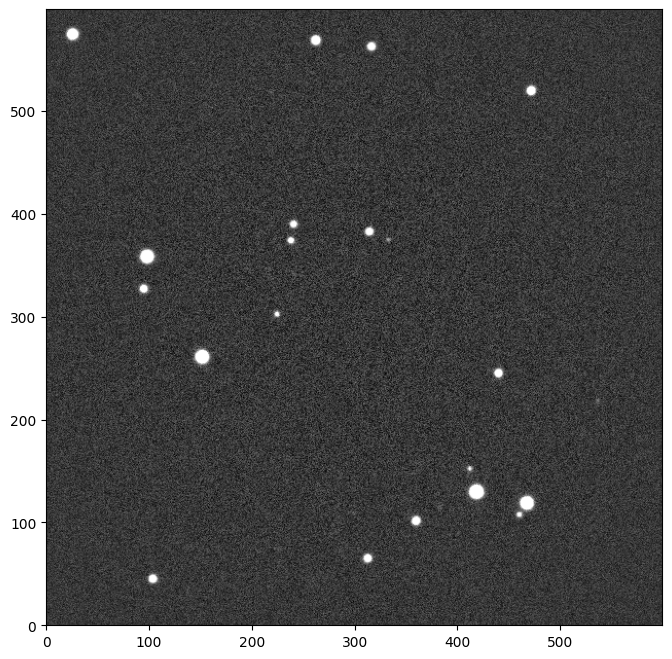

In [ ]:
# Applying the new Block to data

corrected_image = BetterVignettingCorr()(image)
_ = corrected_image.show()

# Catalogues & Plate Solving
---

* Here we are working with objects from catalogues using the SDSS archive, and we will see how to make queries from a catalogue.

## Querying a Catalogue
---

* To query a catalog we can use a catalog block from the *prose.blocks.catalogs* module.
* In cell 4, we see that the *Image.sources* (plotted by default with *image.show*) are set to the queried stars.
* If instead you want to cross-match the queried stars to already existing *Image.sources*, use *catalogs.GaiaCatalog(mode='crossmatch')*.
  * This way the index of the *Image.sources* will be the same as the index in the catalog (see the dataframe from cell 5).
* Seeing the markers on the stars in cell 6 (only with *debug=True*) in the image shows that the plate solving was successful.
* *PlateSolve* is slow so it is not recommended to use this block in a sequence with more than 5 images.
  * Instead, you can pass a plate-solved *ref_image* to this block so that catalog stars are queried only once.

INFO Querying https://archive.stsci.edu/cgi-bin/dss_form


/usr/local/lib/python3.11/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


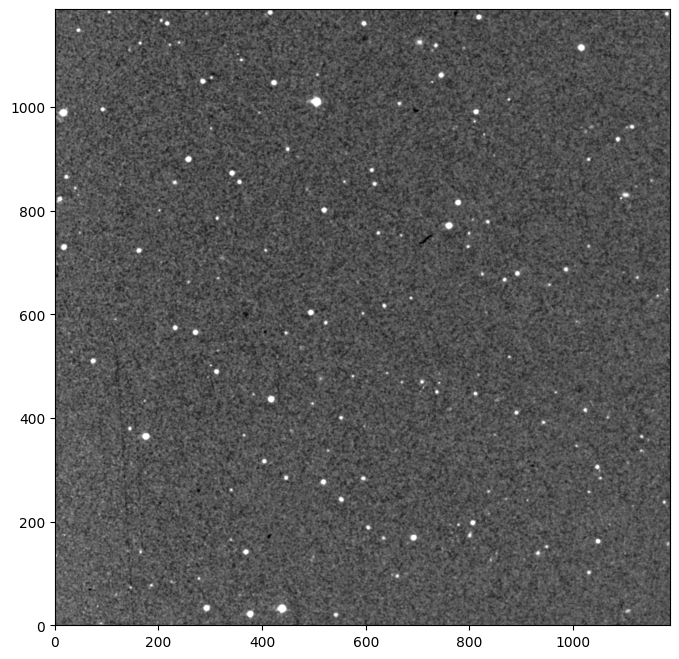

In [ ]:
from prose.archive import sdss_image

# an image of TRAPPIST-1
image = sdss_image(("23 06 29.3684", "-05 02 29.0373"), (20, 20))
image.show()

In [ ]:
# Checks if a plate is solved

image.plate_solved

True

In [ ]:
import warnings

import astropy.units as u
import numpy as np
import pandas as pd
import twirl
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.mast import Catalogs
from twirl.geometry import sparsify

from prose import Block
from prose import visualization as viz
from prose.core.source import PointSource, Sources
from prose.utils import cross_match

__all__ = ["TESSCatalog"]


class _CatalogBlock(Block):
    def __init__(self, name, mode: str = None, limit=10000, **kwargs):
        super().__init__(**kwargs)
        self.mode = mode
        self.catalog_name = name
        self.limit = limit

        if self.mode == "replace":
            self.read = ["sources"]

    def get_catalog(self, image):
        raise NotImplementedError()

    def run(self, image):
        if not image.plate_solved:
            raise ValueError("Image is not plate solved.")
        catalog = self.get_catalog(image)
        radecs = np.array(
            [catalog["ra"].quantity.to(u.deg), catalog["dec"].quantity.to(u.deg)]
        )
        stars_coords = np.array(SkyCoord(*radecs, unit="deg").to_pixel(image.wcs))
        catalog["x"], catalog["y"] = stars_coords
        catalog = catalog.to_pandas()
        image.catalogs[self.catalog_name] = catalog
        stars_coords = stars_coords.T

        if self.mode == "replace":
            mask = np.all(stars_coords < image.shape[::-1], 1) & np.all(
                stars_coords > 0, 1
            )
            mask = mask & ~np.any(np.isnan(stars_coords), 1)
            image.sources = Sources(stars_coords[mask][0 : self.limit])
            catalog = catalog.iloc[np.flatnonzero(mask)].reset_index()

        elif self.mode == "crossmatch":
            coords_1 = image.sources.coords
            coords_2 = catalog[["x", "y"]].values

            _coords_2 = dict(zip(range(len(coords_2)), coords_2))
            tolerance = 10
            matches = {}

            for i, coords in enumerate(coords_1):
                idxs, available_coords = list(zip(*_coords_2.items()))
                distances = np.linalg.norm(available_coords - coords, axis=1)
                if np.all(np.isnan(available_coords)):
                    break
                closest = np.nanargmin(distances)
                if distances[closest] < tolerance:
                    matches[i] = idxs[closest]
                    del _coords_2[idxs[closest]]
                else:
                    matches[i] = None

            new_df_dict = []
            nans = {name: np.nan for name in image.catalogs[self.catalog_name].keys()}

            for i in range(len(coords_1)):
                if matches[i] is not None:
                    new_df_dict.append(
                        dict(image.catalogs[self.catalog_name].iloc[int(matches[i])])
                    )
                    pass
                else:
                    new_df_dict.append(nans)

            catalog = pd.DataFrame(new_df_dict)

        image.catalogs[self.catalog_name] = catalog.iloc[0 : self.limit]


class TESSCatalog(_CatalogBlock):
    def __init__(self, limit=10000, mode=None):
        """Query TESS (TIC) catalog

        Catalog is written in Image.catalogs as a pandas DataFrame. If mode is ""crossmatch" the index of catalog sources in the DataFrame matches with the index of sources in Image.sources

        |read| :code:`Image.sources` if mode is "crossmatch"

        |write| :code:`Image.catalogs`

        - :code:`Image.sources` if mode is "crossmatch"
        - :code:`Image.catalogs`


        Parameters
        ----------
        limit : int, optional
            limit number of stars queried, by default 10000
        mode: str, optional
            "crossmatch" to match existing Image.sources or "replace" to use queried stars as Image.sources
        """
        _CatalogBlock.__init__(self, "tess", limit=limit, mode=mode)

    def get_catalog(self, image):
        max_fov = image.fov.max() * np.sqrt(2) / 2
        table = Catalogs.query_region(
            image.skycoord, radius=max_fov, catalog="TIC", verbose=False
        )
        table["ra"].unit = "deg"
        table["dec"].unit = "deg"
        table.rename_column("ID", "id")
        return table

    def run(self, image):
        _CatalogBlock.run(self, image)

    @property
    def citations(self):
        return super().citations + ["astroquery"]

In [ ]:
# ERROR: Gaia Catalogue closed Jan. 15, 2025 and cannot access (¬_¬)

from prose.blocks import catalogs

image = catalogs.TESSCatalog(mode="replace")(image) #Edit gaia to TESS

# visualizing the catalog stars
image.show()

AttributeError: [TESSCatalog] Image must have sources (0 found)

In [ ]:
# This plots an overlay with labels

# show cutout around 13-th source
cutout = image.cutout(13, 300, reset_index=False)

cutout.show()
cutout.plot_catalog("tess", label=True, color="w")

In [ ]:
image.catalogs["tess"]

In [ ]:
# Plate Solving

from prose import Sequence, blocks

plate = Sequence(
    [
        blocks.detection.PointSourceDetection(n=30),
        blocks.catalogs.PlateSolve(debug=True),
    ]
)

plate.run(image, show_progress=False)

# **Jan. 30, 2025**
---

* I started work on the Case Studies module, beginning with Exoplanet Transit

* Struggled with errors in the Tutorial Plate Solving section due to the Gaia Catalogue being innaccesible, but changed the catalogue to TESS and it worked.

* There was an issue at first creating the path for the images of WAPS-12 b, but I found out that it was the fits images not being synced from my iOS files to my Google Drive files.
  * At the time of my last test of running the cells, maybe about half of the WAPS-12 b images were synced.

# **Case Studies:**
# Exoplanet Transit
---

* This case study of exoplanets reduces [images](https://astrodennis.com/) to find the light curve of WAPS-12 b's transit.

## Managing the FITS
---

* The headers of the images do not denote their type (bias , flat, or dark), so the images have to be grabbed manually without a FitsManager.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Exoplanet Transit

from glob import glob
from pathlib import Path

folder = Path("/content/gdrive/MyDrive/ExoData")

darks = glob(str(folder / "Darks/*.fit"))
bias = glob(str(folder / "Bias/*.fit"))
flats = glob(str(folder / "Flats/*.fit"))
sciences = sorted(glob(str(folder / "ScienceImages/*.fit")))

print(fm.all_images)  # Check if it's empty

if len(fm.all_images) > 0:
         ref = FITSImage(fm.all_images[0])
else:
         print("No images found. Check your folder and file paths.")
         # Handle the case where no images are found (e.g., exit, raise an exception)

['/content/tutorial_dataset/fake-im-0.fits'
 '/content/tutorial_dataset/fake-im-1.fits'
 '/content/tutorial_dataset/fake-im-2.fits'
 '/content/tutorial_dataset/fake-im-3.fits'
 '/content/tutorial_dataset/fake-im-4.fits'
 '/content/tutorial_dataset/fake-im-5.fits'
 '/content/tutorial_dataset/fake-im-6.fits'
 '/content/tutorial_dataset/fake-im-7.fits'
 '/content/tutorial_dataset/fake-im-8.fits'
 '/content/tutorial_dataset/fake-im-9.fits'
 '/content/tutorial_dataset/fake-im-10.fits'
 '/content/tutorial_dataset/fake-im-11.fits'
 '/content/tutorial_dataset/fake-im-12.fits'
 '/content/tutorial_dataset/fake-im-13.fits'
 '/content/tutorial_dataset/fake-im-14.fits'
 '/content/tutorial_dataset/fake-im-15.fits'
 '/content/tutorial_dataset/fake-im-16.fits'
 '/content/tutorial_dataset/fake-im-17.fits'
 '/content/tutorial_dataset/fake-im-18.fits'
 '/content/tutorial_dataset/fake-im-19.fits'
 '/content/tutorial_dataset/fake-im-20.fits'
 '/content/tutorial_dataset/fake-im-21.fits'
 '/content/tutorial_

In [ ]:
import numpy as np
from prose import FITSImage, Sequence, blocks

# reference is middle image
ref = FITSImage(sciences[len(sciences) // 2])

calibration = Sequence(
    [
        blocks.Calibration(darks=darks, bias=bias, flats=flats),
        blocks.Trim(),
        blocks.PointSourceDetection(n=40),  # stars detection
        blocks.Cutouts(21),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.psf.Moffat2D(),  # modeling EPSF
    ]
)

calibration.run(ref, show_progress=False)

photometry = Sequence(
    [
        calibration[0],  # calibration block (same as above)
        blocks.PointSourceDetection(n=12, minor_length=8),  # fewer stars detection
        blocks.Cutouts(21),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.Gaussian2D(ref),  # modeling EPSF with initial guess
        blocks.ComputeTransformTwirl(ref),  # compute alignment
        blocks.AlignReferenceSources(ref),  # alignment
        blocks.CentroidQuadratic(),  # centroiding
        blocks.AperturePhotometry(),  # aperture photometry
        blocks.AnnulusBackground(),  # annulus background
        blocks.GetFluxes(
            "fwhm",
            airmass=lambda im: im.header["AIRMASS"],
            dx=lambda im: im.transform.translation[0],
            dy=lambda im: im.transform.translation[1],
        ),
    ]
)

photometry.run(sciences)

  0%|          | 0/126 [00:00<?, ?images/s]

In [ ]:
photometry

╒═════════╤════════╤═══════════════════════╤════════════════╕
│   index │ name   │ type                  │ processing     │
╞═════════╪════════╪═══════════════════════╪════════════════╡
│       0 │        │ Calibration           │ 1.824 s (3%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       1 │        │ PointSourceDetection  │ 18.731 s (36%) │
├─────────┼────────┼───────────────────────┼────────────────┤
│       2 │        │ Cutouts               │ 2.275 s (4%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       3 │        │ MedianEPSF            │ 0.144 s (0%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       4 │        │ Gaussian2D            │ 5.185 s (10%)  │
├─────────┼────────┼───────────────────────┼────────────────┤
│       5 │        │ ComputeTransformTwirl │ 0.708 s (1%)   │
├─────────┼────────┼───────────────────────┼────────────────┤
│       6 │        │ AlignReferenceSources │ 0.459 s (1%)   │
├───────

In [ ]:
from prose import Fluxes

fluxes: Fluxes = photometry[-1].fluxes

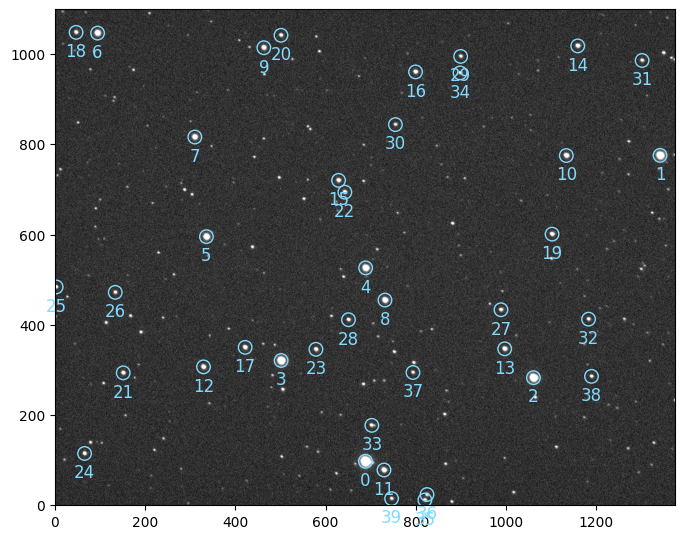

In [ ]:
ref.show()

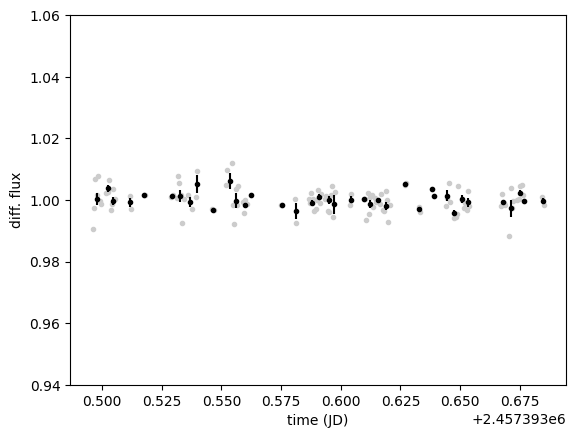

In [ ]:
import matplotlib.pyplot as plt

fluxes.target = 6

# a bit of cleaning
nan_stars = np.any(np.isnan(fluxes.fluxes), axis=(0, 2)) # stars with nan fluxes
fluxes = fluxes.mask_stars(~nan_stars) # mask nans stars
fluxes = fluxes.sigma_clipping_data(bkg=3, fwhm=3) # sigma clipping

# differential photometry
diff = fluxes.autodiff()

# plotting
ax = plt.subplot(xlabel="time (JD)", ylabel="diff. flux", ylim=(0.94, 1.06))
diff.plot()
diff.bin(5 / 60 / 24, estimate_error=True).errorbar()

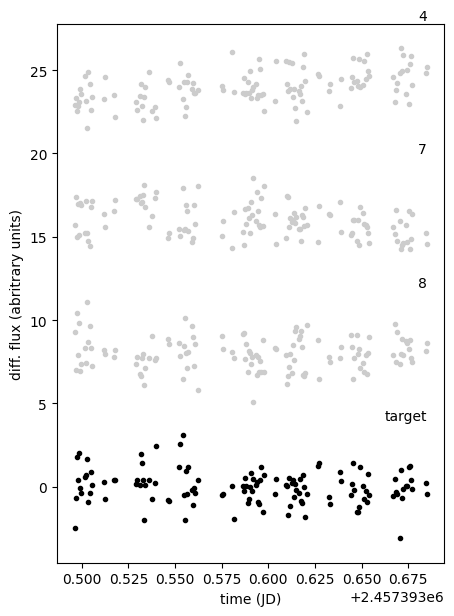

In [ ]:
plt.figure(None, (5, 7))
ax = plt.subplot(xlabel="time (JD)", ylabel="diff. flux (abritrary units)")


# plotting only the first five comparisons
for j, i in enumerate([diff.target, *diff.comparisons[0:5]]):
    y = diff.fluxes[diff.aperture, i].copy()
    y = (y - np.mean(y)) / np.std(y) + 8 * j
    plt.text(
        diff.time.max(), np.mean(y) + 4, i if i != diff.target else "target", ha="right"
    )
    plt.plot(diff.time, y, ".", c="0.8" if i != diff.target else "k")

In [ ]:
diff.dataframe

bkg   airmass        dx        dy      fwhm          time  \
0    263.217450  1.878414  0.049027  0.577561  4.823861  2.457393e+06   
1    264.712805  1.870291 -0.724501  0.477132  4.473182  2.457393e+06   
2    262.381011  1.862163 -0.504950  0.434393  4.369237  2.457393e+06   
3    254.139145  1.854302 -0.590457  0.562448  4.677914  2.457393e+06   
4    254.188870  1.846374 -0.662179  0.459947  4.735866  2.457393e+06   
..          ...       ...       ...       ...       ...           ...   
118  156.662727  1.016858  1.235302  0.514076  4.282152  2.457394e+06   
119  155.995375  1.016596  1.454169  0.665777  4.539481  2.457394e+06   
120  155.549770  1.016337  1.239408  0.540446  4.339912  2.457394e+06   
121  156.771627  1.013881  1.514577  0.617342  4.174981  2.457394e+06   
122  158.541720  1.013758  1.169834  0.650891  4.290458  2.457394e+06   

         flux  
0    0.990487  
1    0.997409  
2    1.006851  
3    1.001542  
4    1.007799  
..        ...  
118  1.004807  
119  1.001697  
120  0.999636  
121  1.000816  
122  0.998411  

[123 rows x 7 columns]

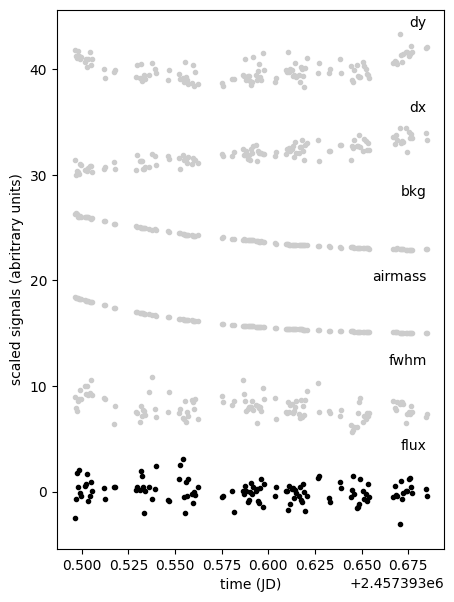

In [ ]:
plt.figure(None, (5, 7))
ax = plt.subplot(xlabel="time (JD)", ylabel="scaled signals (abritrary units)")

for i, name in enumerate(["flux", "fwhm", "airmass", "bkg", "dx", "dy"]):
    y = diff.df[name].copy()
    y = (y - np.mean(y)) / np.std(y) + 8 * i
    plt.text(diff.time.max(), np.mean(y) + 4, name, ha="right")
    plt.plot(diff.time, y, ".", c="0.8" if name != "flux" else "k")

In [ ]:
from prose.core.sequence import SequenceParallel

faster_photometry = SequenceParallel(
    [
        blocks.Calibration(darks=darks, bias=bias, flats=flats, shared=True),
        blocks.PointSourceDetection(
            n=12, minor_length=8
        ),  # stars detection for alignment
        blocks.Cutouts(21),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.Gaussian2D(ref),  # modeling EPSF with initial guess
        blocks.ComputeTransformTwirl(ref),  # compute alignment
        blocks.AlignReferenceSources(ref),  # align sources
        blocks.CentroidQuadratic(),  # centroiding
        blocks.AperturePhotometry(),  # aperture photometry
        blocks.AnnulusBackground(),  # annulus background
        blocks.Del("data", "sources", "cutouts"),  # (optional) reduce overhead
    ],
    [
        blocks.GetFluxes(
            "fwhm",
            airmass=lambda im: im.header["AIRMASS"],
            dx=lambda im: im.transform.translation[0],
            dy=lambda im: im.transform.translation[1],
        ),
    ],
)

faster_photometry.run(sciences)

  0%|          | 0/126 [00:00<?, ?images/s]

# Hi'iaka Occultation
---

In [ ]:
# Hi'iaka Occultation

from prose import FitsManager, utils

fm = FitsManager("/Users/lgrcia/data/Hiaka_occultation_20220609_Artemis", depth=1)
fm.observations(hide_exposure=False)

In [ ]:
from prose import Sequence, blocks, FITSImage

images = fm.all_images
ref = FITSImage(images[0])

calibration = Sequence(
    [
        blocks.Calibration(bias=fm.all_bias, loader=FITSImage),
        blocks.PointSourceDetection(n=1),
    ]
)

calibration.run(ref, show_progress=False, loader=FITSImage)

In [ ]:
import numpy as np

ref.show(zscale=False, sources=False)

radii = np.linspace(1, 6, 20)
for r in radii:
    ref.sources[0].plot(r, label=False, c="w")

rin, rout = 8, 12
ref.sources[0].plot(rin, label=False, c="y")
ref.sources[0].plot(rout, label=False, c="y")

In [ ]:
def copy_sources(image):
    image.sources = ref.sources.copy()


reduction = Sequence(
    [
        *calibration,
        blocks.Apply(copy_sources),  # copy sources from ref
        blocks.CentroidQuadratic(limit=4),  # centroiding
        blocks.AperturePhotometry(scale=False, radii=radii),  # aperture photometry
        blocks.AnnulusBackground(
            scale=False, rin=rin, rout=rout
        ),  # local background estimate
        blocks.Get(path=lambda im: im.metadata["path"]),
        blocks.GetFluxes(),
    ]
)

reduction.run(images, loader=FITSImage)

In [ ]:
import matplotlib.pyplot as plt

fluxes = reduction[-1].fluxes.copy()
fluxes.time -= 2450000

fluxes.target = 0
diff_fluxes = fluxes.diff()
diff_fluxes.estimate_best_aperture(0)
diff_fluxes.plot(color="0.3", ls="-")
_ = plt.xlim(9740.728, 9740.731)

In [ ]:
def plot(image):
    plt.figure(None, (10, 4))
    ax = plt.subplot(121, xlabel="JD-utc - 2450000", ylabel="diff. flux")
    t0 = image.jd - 2450000
    mask = diff_fluxes.time < t0
    ax.plot(diff_fluxes.time[mask], diff_fluxes.flux[mask], ".-", c="0.3")
    plt.xlim(9740.7285, 9740.7305)
    ax.set_ylim(-0.2, 1.3)
    ax.set_title(f"Artemis 2002MS4 occultation ({ref.date.date()})")

    ax2 = plt.subplot(122)
    image.show(zscale=False, ax=ax2, sources=False)
    image.sources.plot(radius=5, ax=ax2)
    plt.tight_layout()

In [ ]:
viz = Sequence([*reduction[0:-2], blocks.VideoPlot(plot, "hiaka.mp4", fps=17)])

# Only the images close to the occultation
occ_images = reduction.get.path[(fluxes.time > 9740.7285) & (fluxes.time < 9740.7305)]
viz.run(occ_images, loader=FITSImage)